### Learning How to Use fastjet
Resources:
- https://fastjet.readthedocs.io/en/latest/Awkward.html#
- https://github.com/scikit-hep/fastjet/blob/main/README.md
- https://github.com/SUEPPhysics/SUEPCoffea_dask

In [1]:
import awkward as ak 
import numpy as np
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
from coffea.nanoevents.schemas.base import zip_forms
import dask_awkward as dak
import hist.dask as hda

In [3]:
events = NanoEventsFactory.from_root( 
    "../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" # make sure you update this path later
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root",
    treepath="events",
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

There is a specfic e+e- kt algorithm however it doesn't seem to work when called. Call is `fastjet.JetDefinition(ee_fastjet.kt_algorithm,0.4)`. There is also `ee_genkt_algorithm` which for $R>2$ and $p=1$ gives ee_kt apparantly. These are probably what we're going to use, I just need to work with them more to figure out what they actually want when called.

In [5]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,0.4) # right now defined with R = 0.4

In [6]:
cluster = fastjet.ClusterSequence(events.PandoraPFOs, jetdef)

In [8]:
# this sets up the jets using Coffea

jets = dak.zip(
    {
        'x': cluster.inclusive_jets()["px"],
        'y': cluster.inclusive_jets()["py"],
        'z': cluster.inclusive_jets()["pz"],
        't': cluster.inclusive_jets()["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


{'from-uproot-4f4439f2df4a4d8dca2ab86fc89242f2': ['PandoraPFOs.z',
  'PandoraPFOs.x',
  'PandoraPFOs.y',
  'PandoraPFOs.t']}

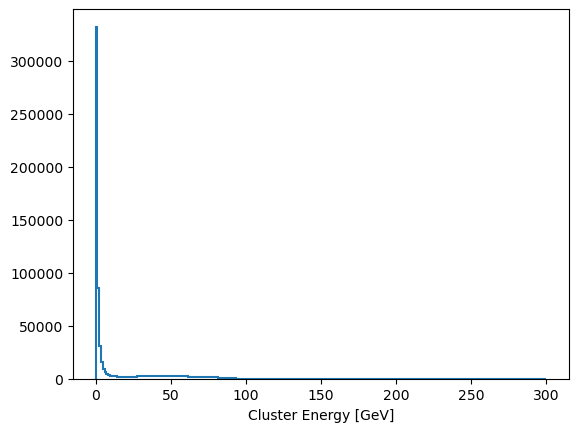

In [9]:
# basic plot

energy_hist_clusters = (
    hda.Hist.new.Reg(250, 0, 300, name="energy", label="Cluster Energy [GeV]") 
    .Double()
    .fill(dak.flatten(jets.energy))
)

energy_hist_clusters.compute().plot1d(label='Jet Clusters')
dak.necessary_columns(energy_hist_clusters)